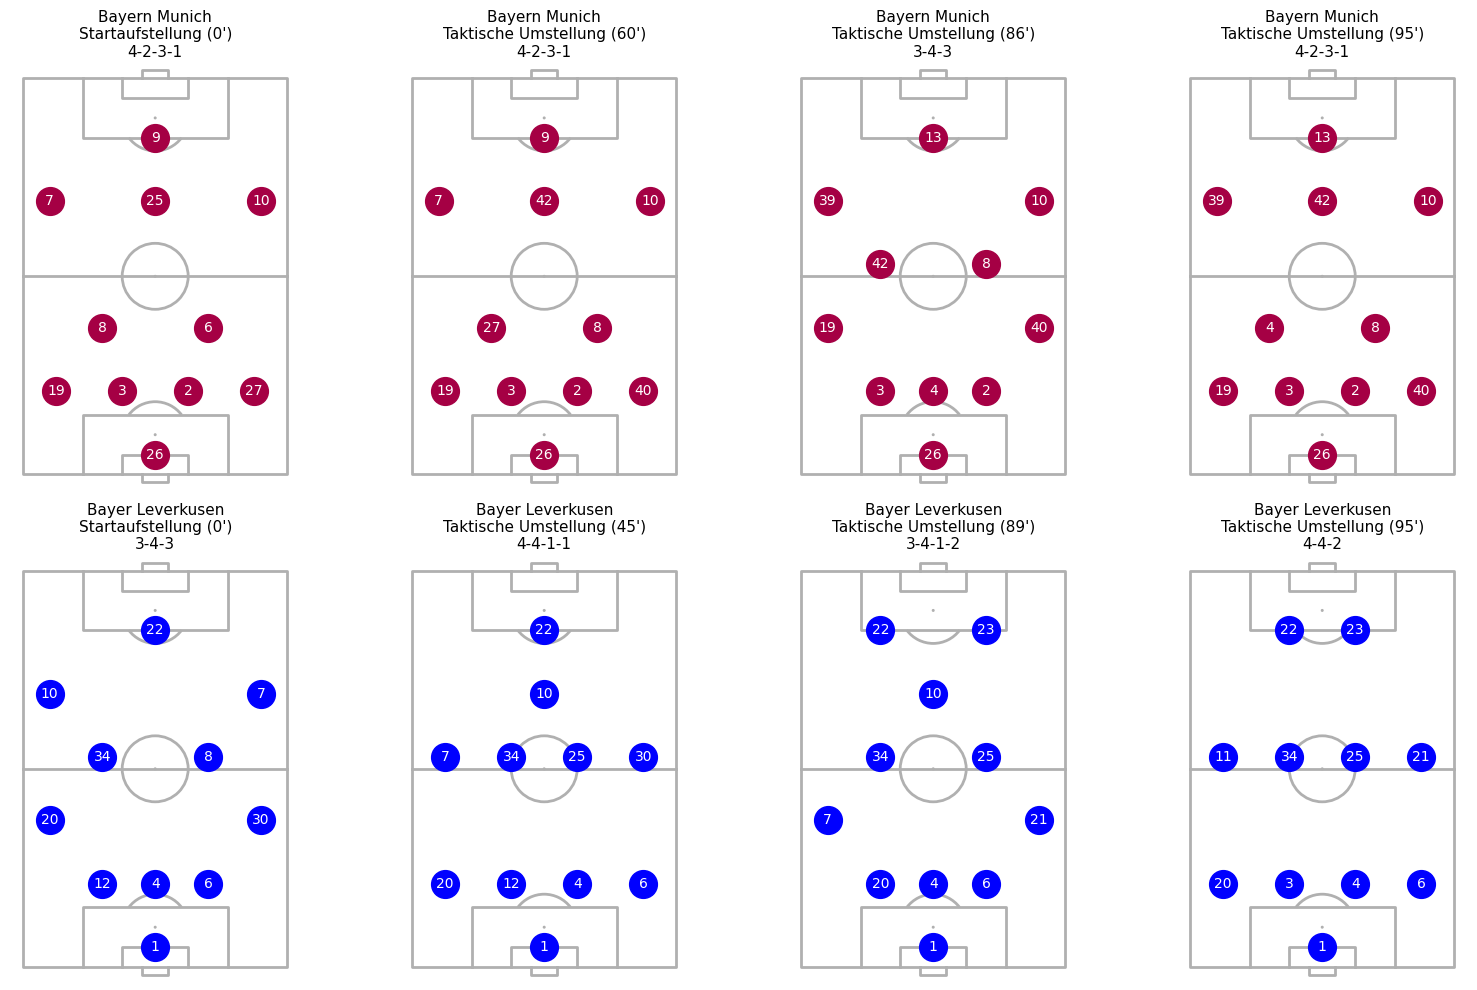

In [1]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import pandas as pd
from statsbombpy import sb

# Match-ID festlegen
match_id = 3895074
events = sb.events(match_id=match_id)

# Team-Infos
teams_df = events[events['type'] == 'Starting XI'][['team_id', 'team']].drop_duplicates()
team_ids = teams_df['team_id'].tolist()
team_names = teams_df['team'].tolist()
team_colors = ['#a50044', 'blue']  # Farben Team 1 & 2

# Alle taktischen Events pro Team sammeln
team_tactical_events = []
max_events = 0

for team_id in team_ids:
    tactical_events = events[
        ((events['type'] == 'Starting XI') | (events['type'] == 'Tactical Shift')) &
        (events['team_id'] == team_id)
    ].sort_values('minute').reset_index(drop=True)

    team_tactical_events.append(tactical_events)
    max_events = max(max_events, len(tactical_events))

# Plot vorbereiten: 2 Reihen (Teams), Spalten = max Anzahl Events
fig, axs = plt.subplots(nrows=2, ncols=max_events, figsize=(max_events * 4, 10))
pitch = VerticalPitch(goal_type='box')

if max_events == 1:
    axs = axs.reshape(2, 1)

# Schleife über beide Teams
for row_idx, (team_id, team_name, color, events_team) in enumerate(zip(team_ids, team_names, team_colors, team_tactical_events)):
    for col_idx in range(max_events):
        ax = axs[row_idx][col_idx]

        if col_idx >= len(events_team):
            ax.axis('off')  # leeres Feld, wenn weniger Events
            continue

        event = events_team.iloc[col_idx]
        tactics = event['tactics']
        formation_str = '-'.join(str(tactics['formation']))
        lineup = tactics['lineup']

        df = pd.DataFrame([{
            'player_id': p['player']['id'],
            'player_name': p['player']['name'],
            'position_id': p['position']['id'],
            'position_name': p['position']['name'],
            'jersey_number': p['jersey_number']
        } for p in lineup])

        pitch.draw(ax=ax)
        pitch.formation(formation_str, positions=df.position_id, kind='scatter',
                        c=color, s=400, xoffset=-6, ax=ax)
        pitch.formation(formation_str, positions=df.position_id, kind='text',
                        text=df['jersey_number'].astype(str), va='center', ha='center',
                        fontsize=10, color='white', xoffset=-6, ax=ax)

        # Titel
        typ = 'Startaufstellung' if event['type'] == 'Starting XI' else 'Taktische Umstellung'
        ax.set_title(f"{team_name}\n{typ} ({event['minute']}')\n{formation_str}", fontsize=11)

plt.tight_layout()
plt.show()